<a href="https://colab.research.google.com/github/aditya-007/Load-forecasting/blob/main/LSTM_load_forecast_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error


In [3]:
data = pd.read_csv('ercot-dataset.csv')

# Drop the 'Date' column since it is not needed for modeling
data_cleaned = data.drop(['Date'], axis=1)

# Display the first few rows and the column names to understand the dataset
data.head(), data.columns

(              Date  DryBulb  DewPnt  WetBulb  Humidity  ElecPrice  Day  Month  \
 0  01/01/2006 0:30     23.9   21.65    22.40      87.5      19.67    1      1   
 1  01/01/2006 1:00     23.9   21.70    22.40      88.0      18.56    1      1   
 2  01/01/2006 1:30     23.8   21.65    22.35      88.0      19.09    1      1   
 3  01/01/2006 2:00     23.7   21.60    22.30      88.0      17.40    1      1   
 4  01/01/2006 2:30     23.7   21.60    22.30      88.0      17.00    1      1   
 
    Year  Minutes     SYSLoad  
 0  2006       30  8013.27833  
 1  2006       60  7726.89167  
 2  2006       90  7372.85833  
 3  2006      120  7071.83333  
 4  2006      150  6865.44000  ,
 Index(['Date', 'DryBulb', 'DewPnt', 'WetBulb', 'Humidity', 'ElecPrice', 'Day',
        'Month', 'Year', 'Minutes', 'SYSLoad'],
       dtype='object'))

In [5]:
# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_cleaned)

# Define the target variable (SYSLoad) and features (everything else)
target_index = data.columns.get_loc('SYSLoad') - 1 # Adjusted due to dropped Date column

In [6]:
# Create sequences for LSTM model input
def create_sequences_lstm(data, target_index, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, :])  # All features over the time step
        Y.append(data[i+time_step, target_index])  # Target value at the next time step
    return np.array(X), np.array(Y)

# Define a time step (how many previous data points to consider)
time_step = 60

# Create the sequences
X, Y = create_sequences_lstm(data_scaled, target_index, time_step)


In [7]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Check the shapes of the prepared training and test sets
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((70070, 60, 10), (17518, 60, 10), (70070,), (17518,))

In [8]:
# Initialize the LSTM model
model = Sequential()

# Add two LSTM layers with 50 units each
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(units=50))

# Add an output layer to predict the SYSLoad
model.add(Dense(units=1))

# Compile the model with Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Train the model on the training set
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/20
1095/1095 [==============================] - 67s 58ms/step - loss: 0.0031 - val_loss: 5.3801e-04
Epoch 2/20
1095/1095 [==============================] - 60s 55ms/step - loss: 3.7705e-04 - val_loss: 2.4962e-04
Epoch 3/20
1095/1095 [==============================] - 59s 54ms/step - loss: 2.0068e-04 - val_loss: 1.3516e-04
Epoch 4/20
1095/1095 [==============================] - 53s 48ms/step - loss: 1.6308e-04 - val_loss: 1.6789e-04
Epoch 5/20
1095/1095 [==============================] - 61s 55ms/step - loss: 1.4956e-04 - val_loss: 1.8805e-04
Epoch 6/20
1095/1095 [==============================] - 62s 56ms/step - loss: 1.3875e-04 - val_loss: 1.1728e-04
Epoch 7/20
1095/1095 [==============================] - 56s 51ms/step - loss: 1.2929e-04 - val_loss: 1.0461e-04
Epoch 8/20
1095/1095 [==============================] - 60s 54ms/step - loss: 1.2726e-04 - val_loss: 1.1185e-04
Epoch 9/20
1095/1095 [==============================] - 61s 56ms/step - loss: 1.1959e-04 - val_loss: 9.4757e

In [10]:
# Make predictions on the training and testing sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

548/548 [==============================] - 7s 13ms/step


In [11]:
# Inverse transform the predictions and the actual values to get the original scale
train_predict = scaler.inverse_transform(
    np.concatenate((np.zeros((train_predict.shape[0], data_cleaned.shape[1] - 1)), train_predict), axis=1)
)[:, -1]  # We add back the other features with zeros before inverse transforming

test_predict = scaler.inverse_transform(
    np.concatenate((np.zeros((test_predict.shape[0], data_cleaned.shape[1] - 1)), test_predict), axis=1)
)[:, -1]

# Similarly, inverse transform the actual SYSLoad values for Y_train and Y_test
Y_train_original = scaler.inverse_transform(
    np.concatenate((np.zeros((Y_train.shape[0], data_cleaned.shape[1] - 1)), Y_train.reshape(-1, 1)), axis=1)
)[:, -1]

Y_test_original = scaler.inverse_transform(
    np.concatenate((np.zeros((Y_test.shape[0], data_cleaned.shape[1] - 1)), Y_test.reshape(-1, 1)), axis=1)
)[:, -1]

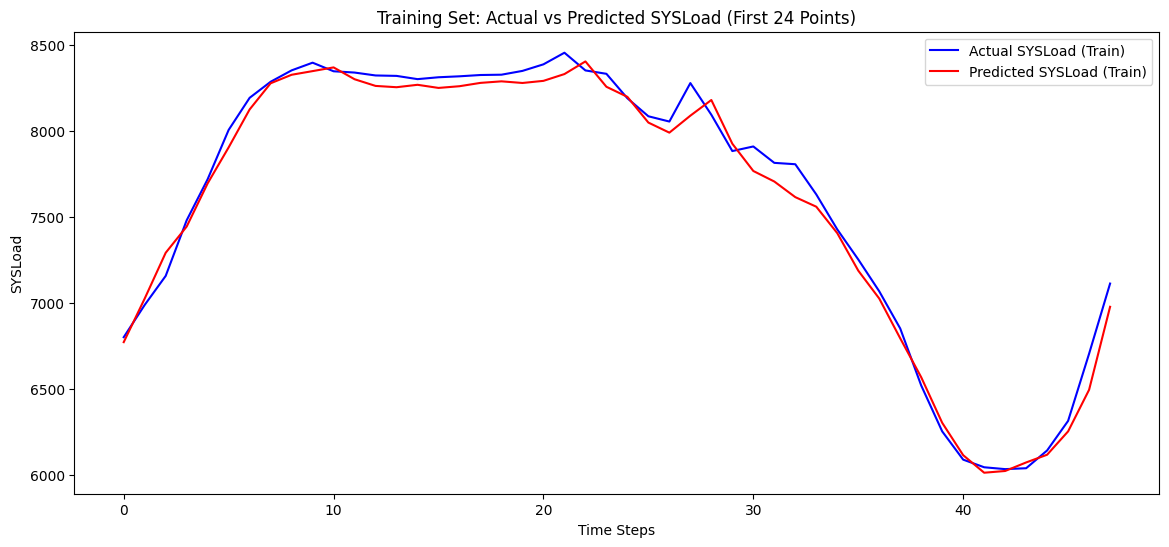

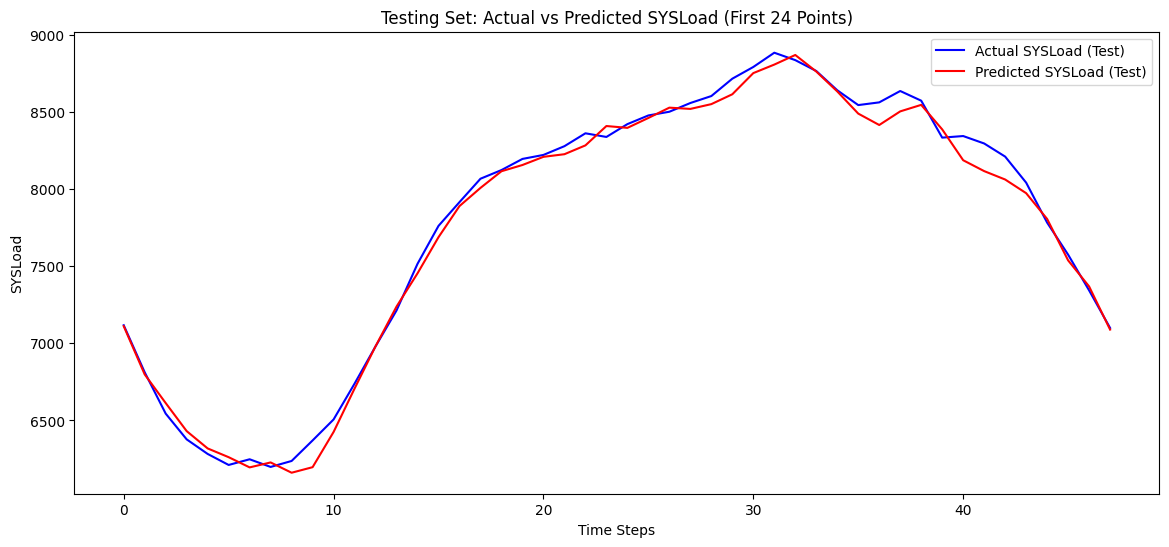

In [14]:
# Plot the first 24 actual vs predicted values for the training set
plt.figure(figsize=(14, 6))
plt.plot(Y_train_original[:48], label='Actual SYSLoad (Train)', color="blue")
plt.plot(train_predict[:48], label='Predicted SYSLoad (Train)', color="red")
plt.title('Training Set: Actual vs Predicted SYSLoad (First 24 Points)')
plt.xlabel('Time Steps')
plt.ylabel('SYSLoad')
plt.legend()
plt.show()

# Plot the first 24 actual vs predicted values for the testing set
plt.figure(figsize=(14, 6))
plt.plot(Y_test_original[:48], label='Actual SYSLoad (Test)', color="blue")
plt.plot(test_predict[:48], label='Predicted SYSLoad (Test)', color="red")
plt.title('Testing Set: Actual vs Predicted SYSLoad (First 24 Points)')
plt.xlabel('Time Steps')
plt.ylabel('SYSLoad')
plt.legend()
plt.show()